<a href="https://colab.research.google.com/github/renan-peres/mfin-portfolio-management/blob/main/01_portfolio_construction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Short-Term Equity Portfolio -- ***30% of Complete Portfolio***
The goal is to select the top 10 most popular stocks on news and selecting a strategy ***(based on sentiment analysis and technical indicators)*** while adhering to these following constraints:

### Step 1: Import Libraries

In [1]:
# System libraries
import glob
import os
import sys
from io import StringIO
from typing import Dict, List

# Data manipulation libraries
import polars as pl
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from pandas.tseries.offsets import BDay

# Visualization libraries
import matplotlib.pyplot as plt
from IPython.display import Image, display

# Backtesting library
import bt

In [2]:
import logging
import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

# Suppress yfinance progress bars
os.environ['YFINANCE_PROGRESS'] = 'False'

# Create logger instance
logger = logging.getLogger(__name__)

logging.getLogger('bt').disabled = True
logging.getLogger('yfinance').disabled = True

# Alternative: Set logging level to critical
logging.getLogger('bt').setLevel(logging.CRITICAL)
logging.getLogger('yfinance').setLevel(logging.CRITICAL)

### Step 2: Define Parameters

#### Date Range

In [3]:
# Define the date range
end_date = (datetime.today() - BDay(1)).to_pydatetime()  # Subtract 1 business day
start_date = end_date - timedelta(days=10*365)            

# Convert datetime objects to Unix timestamps (seconds since Jan 1, 1970)
start_timestamp = int(start_date.timestamp())
end_timestamp = int(end_date.timestamp())

# Print the date range
days_difference = (end_date - start_date).days
print(f"Date Range: {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")
print(f"Time span: {days_difference} days ({days_difference/365:.2f} years)")

Date Range: 2015-06-05 to 2025-06-02
Time span: 3650 days (10.00 years)


#### Risk-free rate (T-bill, %)

In [4]:
from py.utils import load_and_filter_data

daily_risk_free_df = load_and_filter_data('data/daily_treasury_rates.csv', ['^IRX'], start_date, end_date)
# risk_free_rate = .0433
risk_free_rate = daily_risk_free_df.iloc[-1, 0] / 100
print("Risk-Free Rate:", risk_free_rate, "-- 13 WEEK TREASURY BILL (^IRX)")

Found 1 of 1 tickers in data/daily_treasury_rates.csv
Missing tickers: []
Risk-Free Rate: 0.042300000000000004 -- 13 WEEK TREASURY BILL (^IRX)


#### Portfolio File

In [5]:
# Get the most recent portfolio file
portfolio_files = glob.glob('portfolios/portfolio-*.xlsx')
if portfolio_files:
    # Sort files by modification time (most recent first)
    output_file = max(portfolio_files, key=os.path.getmtime)
    print(f"Using most recent portfolio file: {output_file}")
else:
    # Fallback to current date if no files found
    output_file = f'portfolios/portfolio-{datetime.date(end_date)}.xlsx'
    print(f"No portfolio files found. Using: {output_file}")

Using most recent portfolio file: portfolios/portfolio-2025-06-02.xlsx


### Step 3: Import News Data (FMP API)
- API Documentation: https://site.financialmodelingprep.com/developer/docs/stable/stock-news

In [6]:
from py.fetch_fmp_api import create_session, fetch_data
from dotenv import load_dotenv
load_dotenv()

# Get API key from environment variables
FMP_API_KEY = os.getenv('FMP_API_KEY')
if not FMP_API_KEY:
    raise ValueError("FMP_API_KEY not found in environment variables")

# Configuration variables for fetch_data function
DAYS_BACK = 7                    # Number of days to look back for news
MAX_PAGES = 10                   # Maximum number of pages to fetch
RECORDS_PER_PAGE = 1000          # Number of records per page
REQUEST_TIMEOUT = 10             # Timeout for API requests in seconds
API_BASE_URL = "https://financialmodelingprep.com/api/v3/stock_news"
DATE_FORMAT = "%Y-%m-%d %H:%M:%S"  # Date format for parsing publishedDate

# Create session and fetch data with all required parameters
session = create_session()
data = fetch_data(
    api_key=FMP_API_KEY,
    session=session,
    days_back=30,           # Custom: 30 days back
    max_pages=15,           # Custom: 15 pages
    records_per_page=1000,  
    request_timeout=10      
)

news_df = pl.DataFrame(data)
display(news_df.sort('publishedDate', descending=True).head())

Fetching page 1/15...


Page 1: 998 articles fetched
Fetching page 2/15...
Page 2: 1000 articles fetched
Fetching page 3/15...
Page 3: 998 articles fetched
Fetching page 4/15...
Page 4: 1000 articles fetched
Fetching page 5/15...
Page 5: 1000 articles fetched
Fetching page 6/15...
Page 6: 1000 articles fetched
Fetching page 7/15...
Page 7: 999 articles fetched
Fetching page 8/15...
Page 8: 1000 articles fetched
Fetching page 9/15...
Page 9: 996 articles fetched
Fetching page 10/15...
Page 10: 1000 articles fetched
Fetching page 11/15...
Page 11: 1000 articles fetched
Fetching page 12/15...
Page 12: 1000 articles fetched
Fetching page 13/15...
Page 13: 1000 articles fetched
Fetching page 14/15...
Page 14: 1000 articles fetched
Fetching page 15/15...
Page 15: 998 articles fetched
Total articles fetched: 14989


symbol,publishedDate,title,image,site,text,url
str,str,str,str,str,str,str
"""CODI""","""2025-06-03 14:15:00""","""Securities Lawsuit Alert: Comp…","""https://images.financialmodeli…","""accessnewswire.com""","""NEW YORK, NY / ACCESS Newswire…","""https://www.accessnewswire.com…"
"""URGN""","""2025-06-03 14:15:00""","""Class Action Lawsuit Filed Aga…","""https://images.financialmodeli…","""accessnewswire.com""","""NEW YORK, NY / ACCESS Newswire…","""https://www.accessnewswire.com…"
"""IOVA""","""2025-06-03 14:15:00""","""IOVA ALERT: Levi & Korsinsky F…","""https://images.financialmodeli…","""accessnewswire.com""","""NEW YORK CITY, NY / ACCESS New…","""https://www.accessnewswire.com…"
"""ET""","""2025-06-03 14:11:27""","""7.5% Yield, AI Growth, And Dir…","""https://images.financialmodeli…","""seekingalpha.com""","""Energy Transfer LP offers a co…","""https://seekingalpha.com/artic…"
"""IVV""","""2025-06-03 14:09:12""","""S&P 500 Update: 6100-6200 Is N…","""https://images.financialmodeli…","""fxempire.com""","""The rally from the April lows …","""https://www.fxempire.com/forec…"


### Step 4: Sentiment Analysis
- Use `TextBlob` for sentiment analysis on news headlines.


In [7]:
from py.sentiment_analysis import calculate_stock_sentiment_metrics, get_fundamental_value, calculate_sector_averages

# Load fundamental data and prepare ticker lists
print("Loading fundamental data...")
fundamentals_df = pl.read_csv('data/fundamentals_stock.csv')
fundamentals_pandas = fundamentals_df.to_pandas().set_index('Ticker')
all_tickers = set(news_df['symbol'].to_list() + fundamentals_df['Ticker'].to_list())
EXCLUDED_SYMBOLS = {'AI', 'S', 'A', 'U', 'E', 'US', 'ET', 'TSXV', 'CODI', 'C'}

print(f"Loaded {len(fundamentals_df)} stocks, {len(all_tickers)} unique tickers")

# Execute sentiment analysis
print("Analyzing sentiment for stock symbols...")
sentiment_metrics = calculate_stock_sentiment_metrics(news_df, all_tickers, EXCLUDED_SYMBOLS)
sentiment_df = pl.DataFrame([{
    "symbol": symbol, "articlesInLastWeek": metrics["articlesInLastWeek"],
    "companyNewsScore": metrics["companyNewsScore"], 
    "bearishPercent": metrics["sentiment"]["bearishPercent"],
    "bullishPercent": metrics["sentiment"]["bullishPercent"],
    "averageSentimentScore": metrics["averageSentimentScore"],
    "totalArticles": metrics["totalArticles"]
} for symbol, metrics in sentiment_metrics.items()]).sort(["articlesInLastWeek", "companyNewsScore"], descending=[True, True])

# Add fundamental data and sector averages
sector_averages = calculate_sector_averages(sentiment_df, fundamentals_pandas)
sentiment_with_fundamentals = sentiment_df.with_columns([
    pl.col("symbol").map_elements(lambda x: sector_averages.get(get_fundamental_value(x, 'Sector', 'Unknown'), {}).get('sectorAverageBullishPercent', 0), return_dtype=pl.Float64).alias("sectorAverageBullishPercent"),
    pl.col("symbol").map_elements(lambda x: sector_averages.get(get_fundamental_value(x, 'Sector', 'Unknown'), {}).get('sectorAverageNewsScore', 0), return_dtype=pl.Float64).alias("sectorAverageNewsScore"),
    pl.col("symbol").map_elements(lambda x: get_fundamental_value(x, 'Sector', 'Unknown'), return_dtype=pl.Utf8).alias("sector"),
    pl.col("symbol").map_elements(lambda x: get_fundamental_value(x, 'Market Cap'), return_dtype=pl.Float64).alias("marketCap"),
    pl.col("symbol").map_elements(lambda x: get_fundamental_value(x, 'P/E (trailing)'), return_dtype=pl.Float64).alias("peRatio"),
    pl.col("symbol").map_elements(lambda x: get_fundamental_value(x, 'Price'), return_dtype=pl.Float64).alias("price")
])

# Screen stocks and analyze sectors
comprehensive_screened = sentiment_with_fundamentals.filter((pl.col("articlesInLastWeek") >= 3) & (pl.col("companyNewsScore") >= 0.45)).sort(["companyNewsScore", "articlesInLastWeek"], descending=[True, True])
sector_summary = sentiment_with_fundamentals.filter(pl.col("sector") != "Unknown").group_by("sector").agg([
    pl.count("symbol").alias("stock_count"), pl.mean("companyNewsScore").alias("avg_news_score"),
    pl.mean("bullishPercent").alias("avg_bullish_percent"), pl.mean("articlesInLastWeek").alias("avg_articles"),
    pl.mean("marketCap").alias("avg_market_cap"), pl.mean("peRatio").alias("avg_pe_ratio")
]).sort("avg_news_score", descending=True)

print(f"\nScreened {len(comprehensive_screened)} stocks, {len(sector_averages)} sectors")
display(comprehensive_screened.head())
display(sector_summary)

Loading fundamental data...
Loaded 504 stocks, 4236 unique tickers
Analyzing sentiment for stock symbols...

Screened 1677 stocks, 11 sectors


symbol,articlesInLastWeek,companyNewsScore,bearishPercent,bullishPercent,averageSentimentScore,totalArticles,sectorAverageBullishPercent,sectorAverageNewsScore,sector,marketCap,peRatio,price
str,i64,f64,f64,f64,f64,i64,f64,f64,str,f64,f64,f64
"""BGM""",4,0.9,0.0,1.0,0.8,4,0.0,0.0,"""Unknown""",0.0,0.0,0.0
"""CAE""",4,0.8,0.0,1.0,0.6,4,0.0,0.0,"""Unknown""",0.0,0.0,0.0
"""BBY""",21,0.7933,0.0,1.0,0.5865,21,0.4494,0.5625,"""Consumer Cyclical""",1.4031e10,16.17,66.28
"""NSCIF""",3,0.7803,0.0,1.0,0.5606,3,0.0,0.0,"""Unknown""",0.0,0.0,0.0
"""AGS""",3,0.775,0.0,1.0,0.55,3,0.0,0.0,"""Unknown""",0.0,0.0,0.0


sector,stock_count,avg_news_score,avg_bullish_percent,avg_articles,avg_market_cap,avg_pe_ratio
str,u32,f64,f64,f64,f64,f64
"""Utilities""",29,0.585979,0.561438,16.793103,4.1626e10,21.179655
"""Healthcare""",55,0.584838,0.591362,19.036364,8.7055e10,NaN
"""Communication Services""",19,0.572821,0.579484,25.210526,3.9771e11,NaN
"""Technology""",78,0.568142,0.513336,16.820513,2.1434e11,NaN
"""Consumer Cyclical""",51,0.562525,0.449402,13.215686,1.1462e11,NaN
…,…,…,…,…,…,…
"""Consumer Defensive""",31,0.558184,0.504029,16.064516,1.0506e11,NaN
"""Real Estate""",28,0.555468,0.435532,8.392857,3.6466e10,NaN
"""Energy""",22,0.550845,0.372695,6.136364,6.8922e10,NaN


### Step 5: Select Top 100 stocks ***(by `averageSentimentScore`)***
- Constrained by being part of the s&p 500 index and not already in the portfolio long-term portfolio.

In [8]:
# Load long-term portfolio and select top sentiment stocks
long_term_tickers = pl.read_excel(output_file, sheet_name='long_term')['Ticker'].to_list()
print(f"Excluding {len(long_term_tickers)} tickers already in long-term portfolio: {long_term_tickers}")

selected_stocks = (comprehensive_screened
    .filter(pl.col("sector") != 'Unknown')
    .filter(~pl.col("symbol").is_in(long_term_tickers))
    .sort("averageSentimentScore", descending=True)
    .head(100))

screened_tickers = selected_stocks['symbol'].to_list()
print(f"\nSelected {len(screened_tickers)} stocks with highest sentiment scores")
display(selected_stocks.head())

# Sector distribution and summary statistics
sector_distribution = selected_stocks.group_by("sector").agg([
    pl.count("symbol").alias("stock_count"),
    pl.mean("averageSentimentScore").alias("avg_sentiment_score"),
    pl.mean("companyNewsScore").alias("avg_news_score"),
    pl.mean("bullishPercent").alias("avg_bullish_percent")
]).sort("stock_count", descending=True)

print(f"\nSector distribution:")
display(sector_distribution.head())

# Show summary statistics
print(f"\nSummary statistics for selected stocks:")
print(f"Average sentiment score: {selected_stocks['averageSentimentScore'].mean():.4f}")
print(f"Min sentiment score: {selected_stocks['averageSentimentScore'].min():.4f}")
print(f"Max sentiment score: {selected_stocks['averageSentimentScore'].max():.4f}")
print(f"Average company news score: {selected_stocks['companyNewsScore'].mean():.4f}")
print(f"Number of stocks: {selected_stocks['symbol'].count()}")
print(f"Number of unique sectors: {selected_stocks['sector'].n_unique()}")

Excluding 5 tickers already in long-term portfolio: ['MMC', 'TMUS', 'APO', 'SO', 'AMAT']

Selected 100 stocks with highest sentiment scores


symbol,articlesInLastWeek,companyNewsScore,bearishPercent,bullishPercent,averageSentimentScore,totalArticles,sectorAverageBullishPercent,sectorAverageNewsScore,sector,marketCap,peRatio,price
str,i64,f64,f64,f64,f64,i64,f64,f64,str,f64,f64,f64
"""BBY""",21,0.7933,0.0,1.0,0.5865,21,0.4494,0.5625,"""Consumer Cyclical""",1.4031e10,16.17,66.28
"""ZTS""",5,0.7097,0.0,1.0,0.4194,5,0.5914,0.5848,"""Healthcare""",7.5075e10,30.33,168.63
"""NXPI""",4,0.7,0.0,0.5,0.4,4,0.5133,0.5681,"""Technology""",4.8285e10,20.84,191.13
"""FI""",10,0.6911,0.0,0.8,0.3822,10,0.5133,0.5681,"""Technology""",9.0256e10,28.81,162.79
"""AES""",9,0.6836,0.0,0.7778,0.3673,9,0.5614,0.586,"""Utilities""",7.1833e9,5.48,10.09



Sector distribution:


sector,stock_count,avg_sentiment_score,avg_news_score,avg_bullish_percent
str,u32,f64,f64,f64
"""Industrials""",18,0.237033,0.618522,0.781417
"""Technology""",17,0.250112,0.625059,0.742176
"""Utilities""",13,0.253177,0.626585,0.659062
"""Healthcare""",12,0.264808,0.632392,0.754917
"""Consumer Cyclical""",11,0.254327,0.627173,0.701845



Summary statistics for selected stocks:
Average sentiment score: 0.2421
Min sentiment score: 0.1708
Max sentiment score: 0.5865
Average company news score: 0.6211
Number of stocks: 100
Number of unique sectors: 11


### Step 6: Import Stock Quotes

In [9]:
from py.utils import suppress_output
quotes = suppress_output(bt.get, screened_tickers, start=start_date, end=end_date)
display(quotes.tail())

,bby,zts,nxpi,fi,aes,lhx,dhr,ual,syk,peg,...,gev,dal,cl,yum,cvx,sbux,ups,mrna,wsm,avb
Date,,,,,,,,,,,,,,,,,,,,,
2025-05-27,72.220001,166.259995,198.899994,160.139999,10.07,247.899994,189.179993,78.180000,383.779999,79.599998,...,471.510010,49.400002,92.430000,144.089996,137.830002,87.010002,97.550003,26.760000,166.830002,201.460007
2025-05-28,71.519997,165.399994,196.210007,160.740005,9.70,244.369995,189.009995,77.500000,380.390015,78.089996,...,485.010010,48.599998,91.760002,143.149994,136.020004,86.000000,96.739998,26.049999,164.509995,201.979996
2025-05-29,66.320000,167.139999,195.889999,159.619995,10.05,243.419998,190.470001,78.570000,382.350006,79.550003,...,471.170013,48.500000,92.300003,144.039993,137.910004,84.050003,98.099998,26.930000,164.509995,206.020004
2025-05-30,66.279999,168.630005,191.130005,162.789993,10.09,244.339996,189.899994,79.440002,382.640015,81.029999,...,472.980011,48.389999,92.940002,143.940002,136.699997,83.949997,97.540001,26.559999,161.759995,206.770004
2025-06-02,68.269997,169.419998,192.809998,162.000000,10.18,243.160004,189.229996,81.230003,380.859985,81.900002,...,485.160004,48.500000,91.930000,144.630005,137.839996,85.190002,97.360001,27.049999,158.220001,207.149994


### Step 7: Create Trading Signals
- Use `talib` library to create signals.

In [10]:
from py.technical_analysis import calculate_technical_indicators, generate_trading_signals

# Execute technical analysis
technical_indicators = calculate_technical_indicators(quotes)
trading_signals = generate_trading_signals(technical_indicators)
available_tickers = list(technical_indicators.keys())

# Display sample results for first ticker
sample_ticker = available_tickers[0]
print(f"\nSample indicators and signals for {sample_ticker}:")
display(technical_indicators[sample_ticker].tail())

✅ Technical indicators calculated for 100 tickers
✅ Trading signals generated for 100 tickers

Sample indicators and signals for bby:


,Close,SMA_20,SMA_50,SMA_200,EMA_12,EMA_26,EMA_50,ADX,PLUS_DI,MINUS_DI,RSI_14,RSI_21
Date,,,,,,,,,,,,
2025-05-27,72.220001,70.1220,68.385867,82.859095,70.909820,69.876582,70.722142,13.779280,57.050909,42.949091,57.050909,53.703035
2025-05-28,71.519997,70.3640,68.359390,82.817231,71.003694,69.998316,70.753431,13.475742,54.764869,45.235131,54.764869,52.382631
2025-05-29,66.320000,70.3455,68.241552,82.743705,70.283125,69.725848,70.579571,13.731621,41.470973,58.529027,41.470973,43.953333
2025-05-30,66.279999,70.3075,68.109880,82.682221,69.667260,69.470600,70.410960,13.981113,41.387744,58.612256,41.387744,43.896279
2025-06-02,68.269997,70.3175,68.024130,82.621300,69.452296,69.381667,70.327001,13.399889,47.078013,52.921987,47.078013,47.458882


### Step 8: Backtest Strategies and Select Top 10 Stocks ***(by CAGR & Volatility)***
- Use `bt` library for backtesting the strategy.

In [11]:
from py.technical_analysis import run_backtest, best_strategy_analysis

# Configuration constants
PORTFOLIO_CONFIG = {
    'max_volatility': 0.3,  # Maximum 30% volatility
    'max_stocks': 2        # Maximum 10 stocks in portfolio
}

# Step 1: Run strategy backtesting
backtest_data = run_backtest(quotes, trading_signals, available_tickers)

# Step 2: Analyze best strategies and build portfolio
analysis_results = best_strategy_analysis(quotes, trading_signals, backtest_data, available_tickers, **PORTFOLIO_CONFIG)

# Step 3: Display results
selected_tickers = analysis_results['selected_tickers']
best_strategies_df = analysis_results['best_strategies_df']
print(f"\n📊 Best Strategies for {len(selected_tickers)} Selected Tickers:")
display(best_strategies_df.sort_values('cagr', ascending=False))

STRATEGY BACKTESTING ANALYSIS

🔄 Running strategy backtests...
🔄 Running 400 backtests silently...
  Progress: 5%
  Progress: 10%
  Progress: 15%
  Progress: 20%
  Progress: 25%
  Progress: 30%
  Progress: 35%
  Progress: 40%
  Progress: 45%
  Progress: 50%
  Progress: 55%
  Progress: 60%
  Progress: 65%
  Progress: 70%
  Progress: 75%
  Progress: 80%
  Progress: 85%
  Progress: 90%
  Progress: 95%
  Progress: 100%
✅ Backtesting completed

🔄 Portfolio Construction
📊 CAGR Filtering: 100 → 90 tickers (≥0.0%)
📊 Volatility Filtering: → 69 tickers (≤30.0%)
🏆 Selected top 2 performers:
  #1. lmt: 43.68% CAGR, 21.46% Vol, Sharpe: 1.80 (SMA_Cross_Signal)
  #2. pm: 38.91% CAGR, 23.48% Vol, Sharpe: 1.52 (EMA_Cross_Signal)

🔄 Portfolio Backtesting
✅ Strategy Analysis Complete!

📈 Portfolio: 2 stocks
  📊 Avg CAGR: 41.29% | Avg Sharpe: 1.66 | Avg Volatility: 22.47% | Avg Drawdown: -18.32%
  🎯 Strategy Distribution:
    - SMA_Cross_Signal: 1 stocks (50.0%)
    - EMA_Cross_Signal: 1 stocks (50.0%)

📊

,cagr,total_return,max_drawdown,sharpe_ratio,volatility,strategy
lmt,0.436772,0.529070,-0.132229,1.802865,0.214643,SMA_Cross_Signal
pm,0.389079,0.469763,-0.234093,1.524161,0.234830,EMA_Cross_Signal


### Step 9: Run a Loop to Try the Strategy with Different Parameters

In [12]:
%%capture
from py.technical_analysis import optimize_strategy_parameters, create_optimization_summary

print("=" * 80)
print("PARAMETER OPTIMIZATION")
print("=" * 80)

# Run parameter optimization
optimization_results = optimize_strategy_parameters(
    quotes=quotes,
    best_strategies_df=best_strategies_df,
    selected_tickers=selected_tickers,
    risk_free_rate=risk_free_rate
)

# Create summary of optimized parameters
optimization_summary = create_optimization_summary(optimization_results)

In [13]:
display(optimization_summary)

,Ticker,Strategy,Best_Sharpe,CAGR,Max_Drawdown,Volatility,Short_Period,Long_Period
0,lmt,SMA_Cross_Signal,1.870163,0.457274,-0.132163,0.214527,23,50
1,pm,EMA_Cross_Signal,2.328517,0.701969,-0.080925,0.241939,10,33


### Step 9: Plot Results

📊 Generating Portfolio Charts...

📈 Parameter Optimization Visualization:


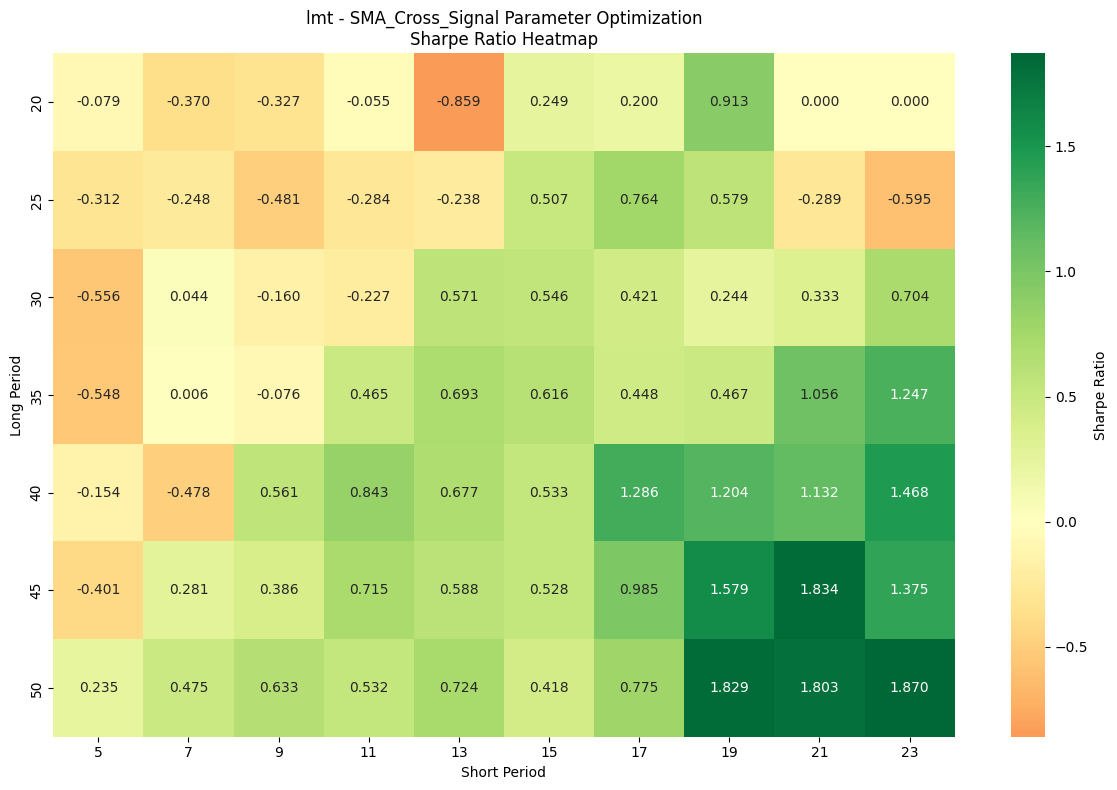

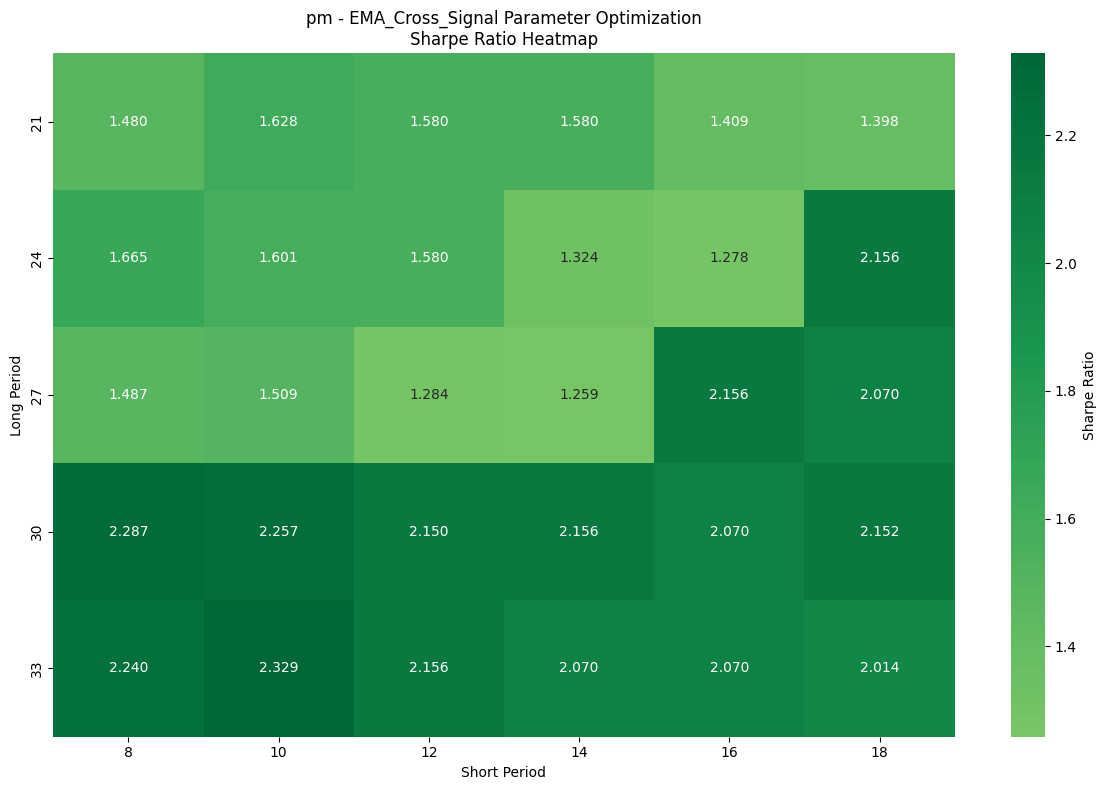

<Figure size 1500x1000 with 0 Axes>

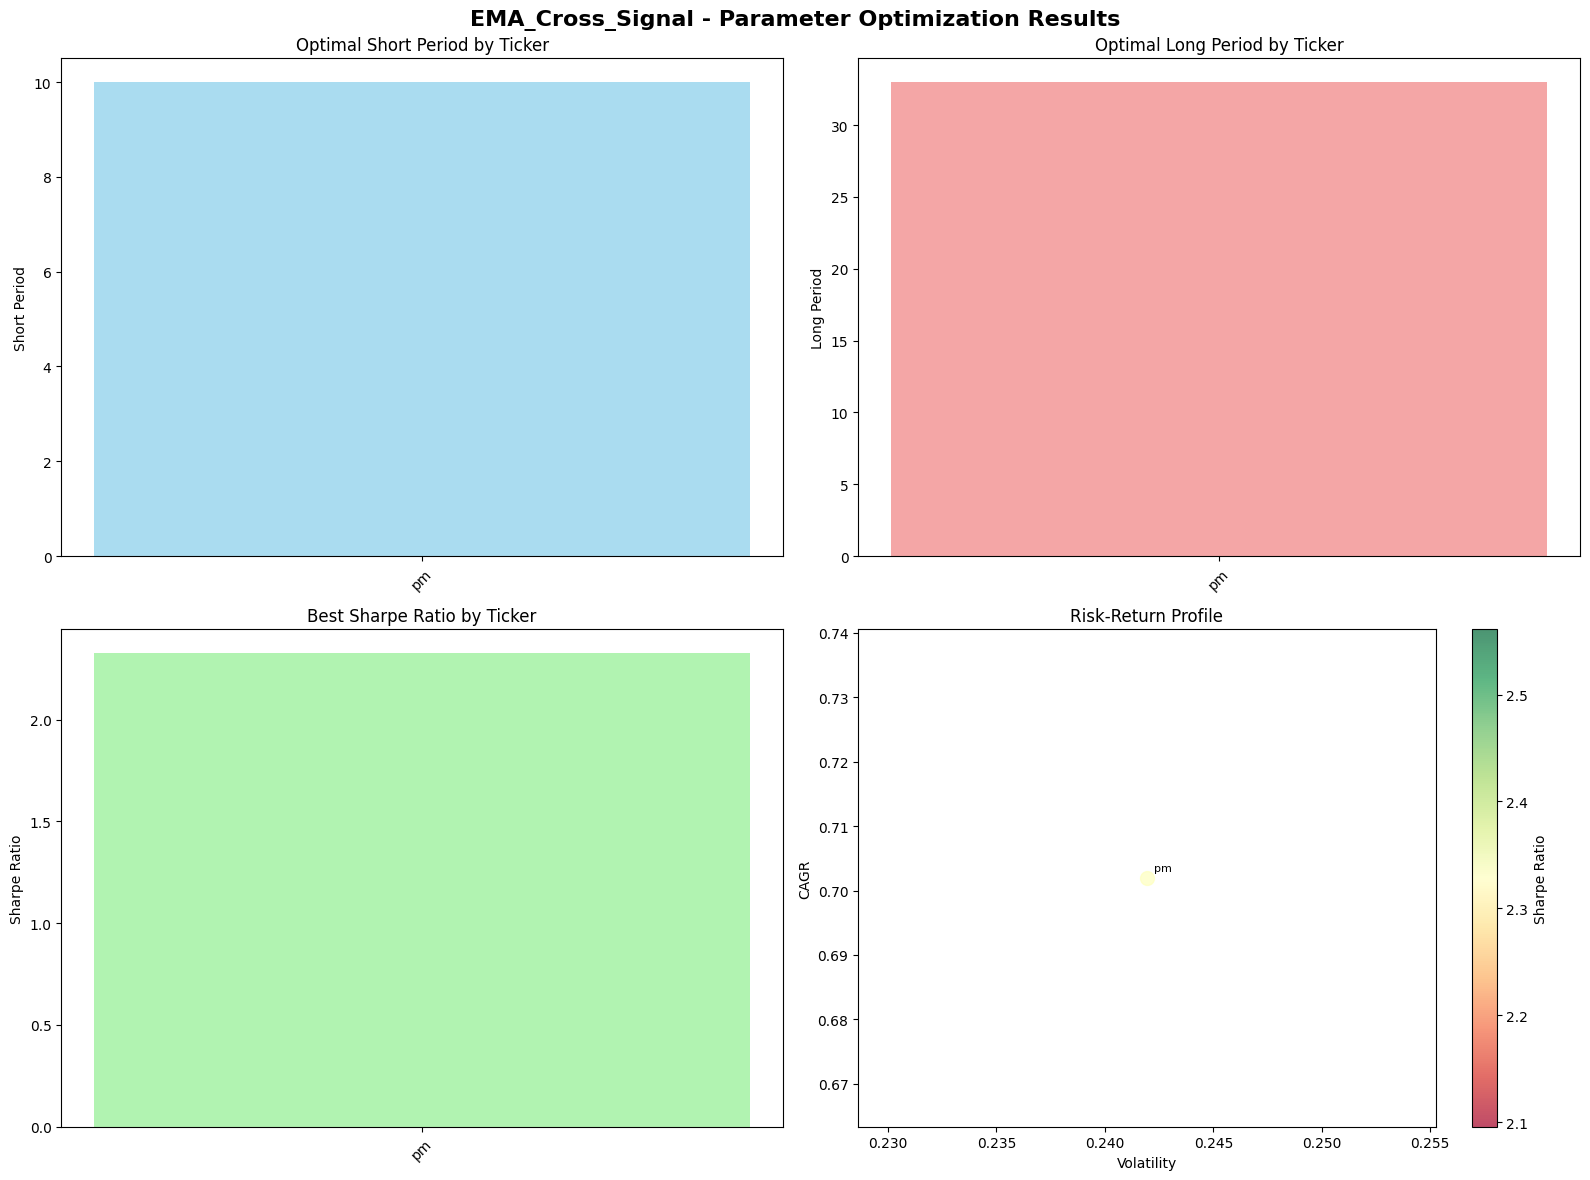

<Figure size 1500x1000 with 0 Axes>

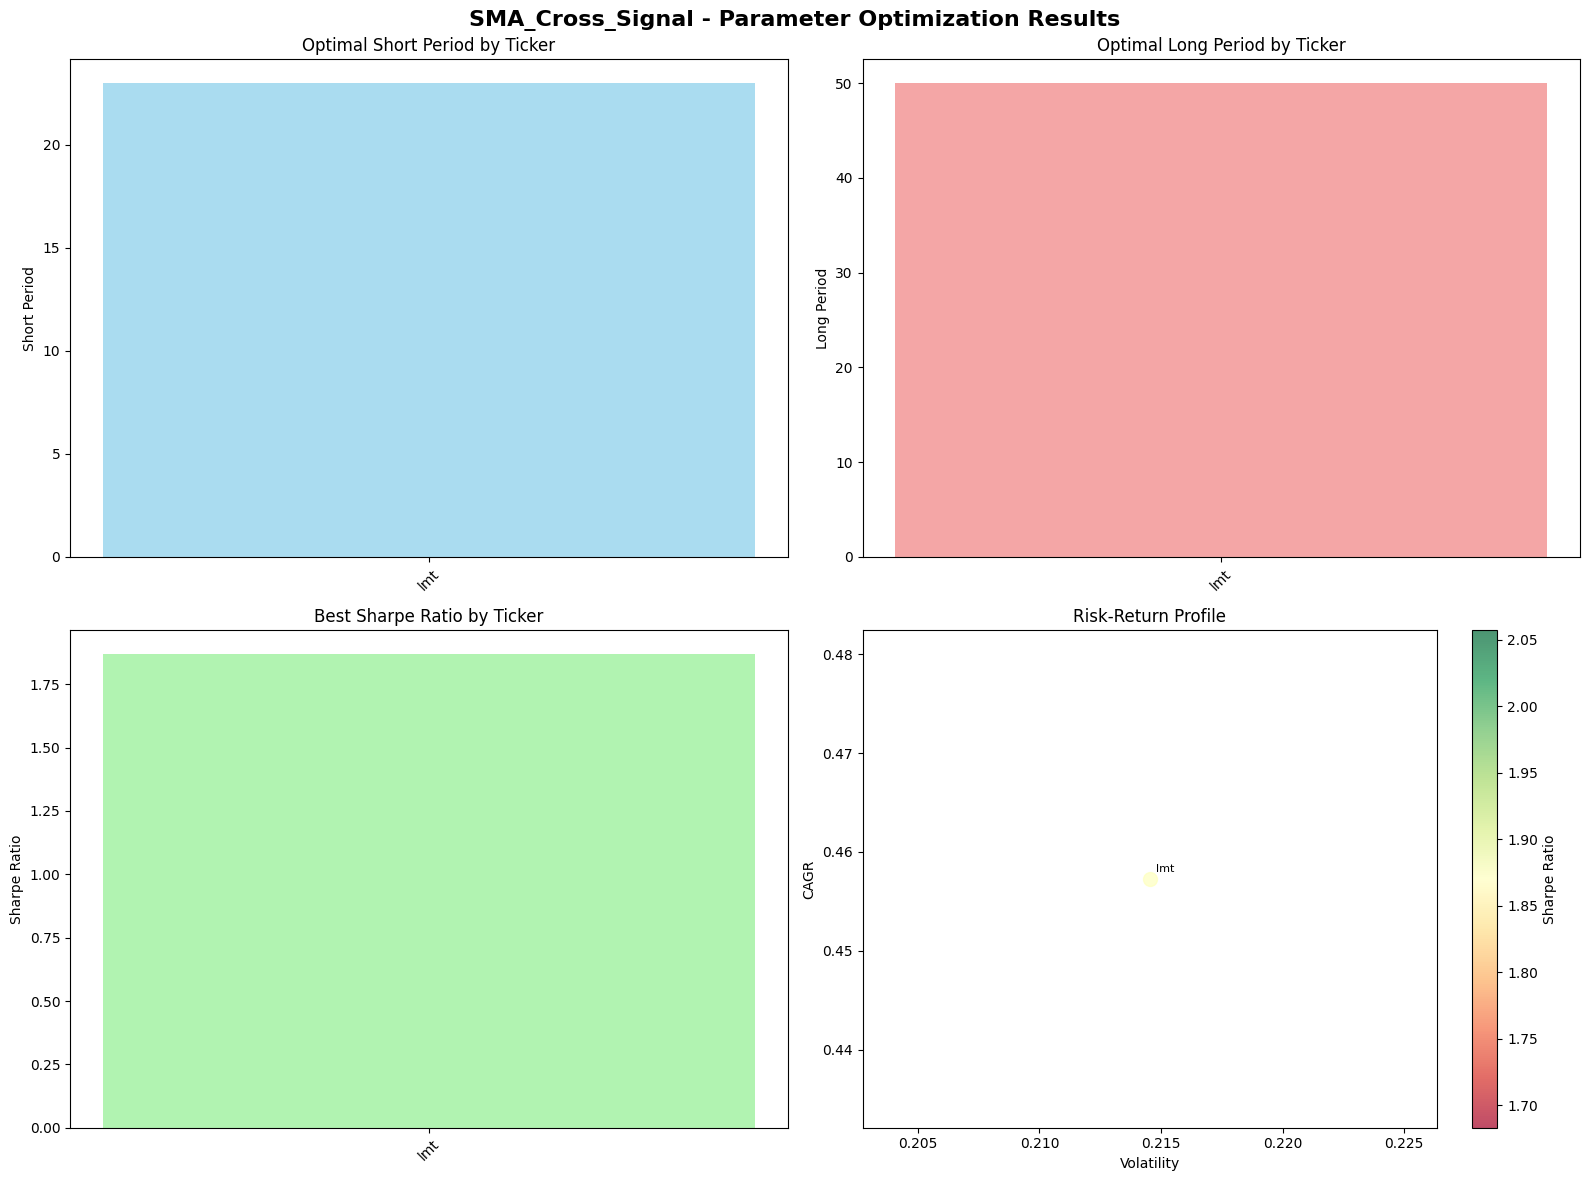

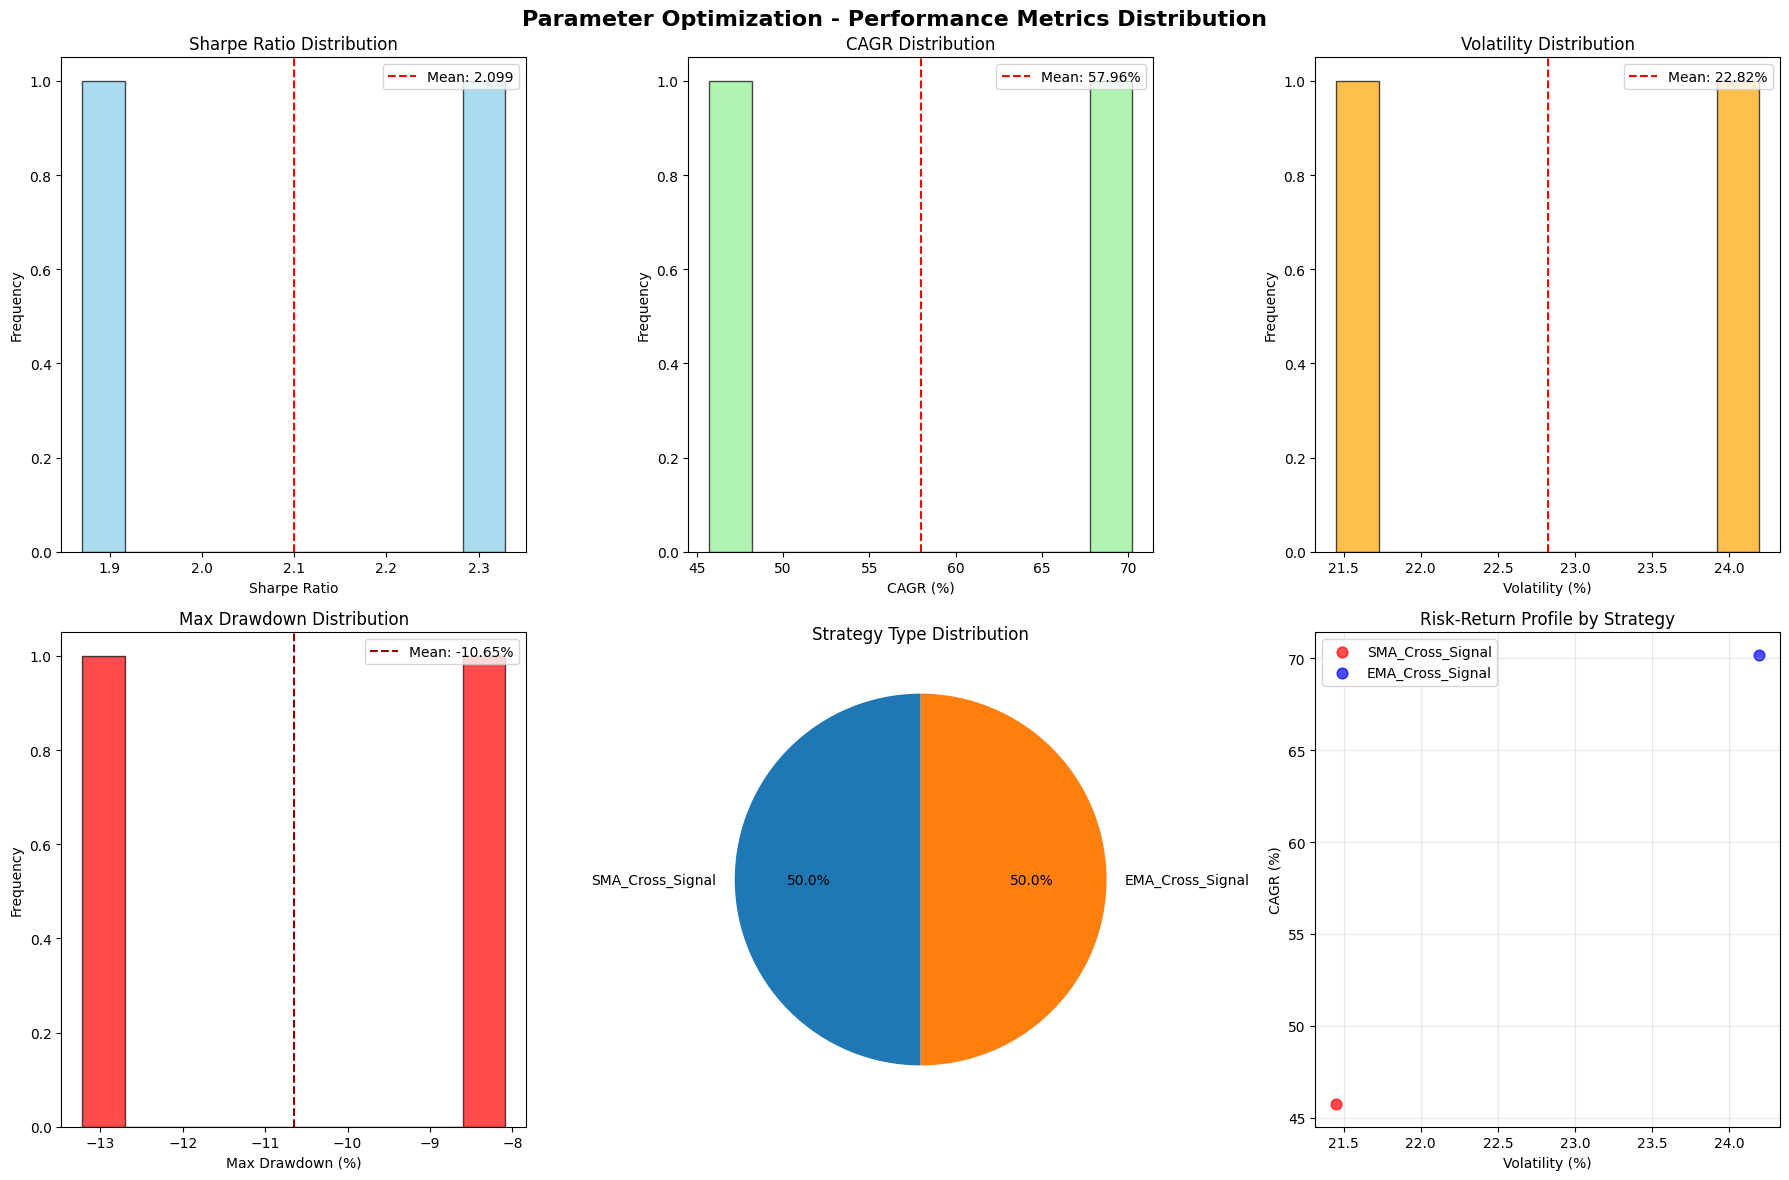


📈 Portfolio Performance:


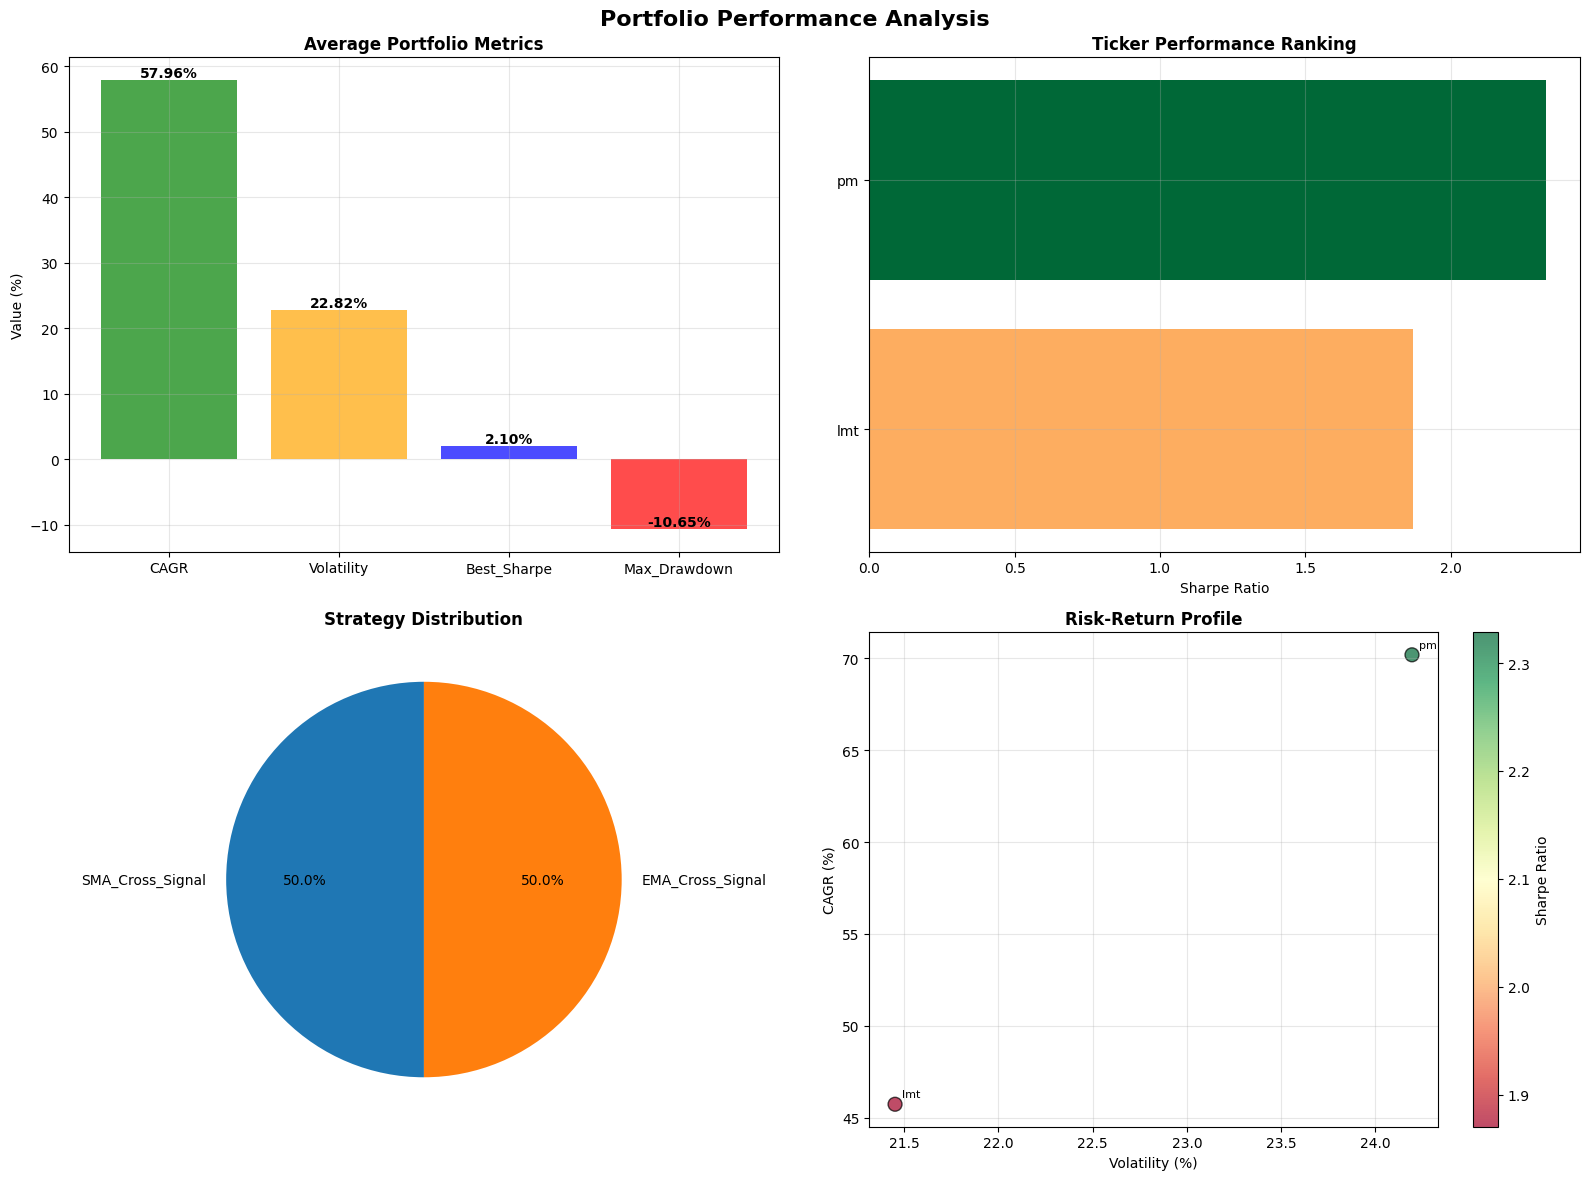


📊 Portfolio Summary:
  • Number of stocks: 2
  • Average CAGR: 57.96%
  • Average Volatility: 22.82%
  • Average Sharpe Ratio: 2.099
  • Average Max Drawdown: -10.65%
  • Best performer: pm (Sharpe: 2.329)

📈 Strategy Signals by Ticker:
📋 Included tickers: ['lmt', 'pm']


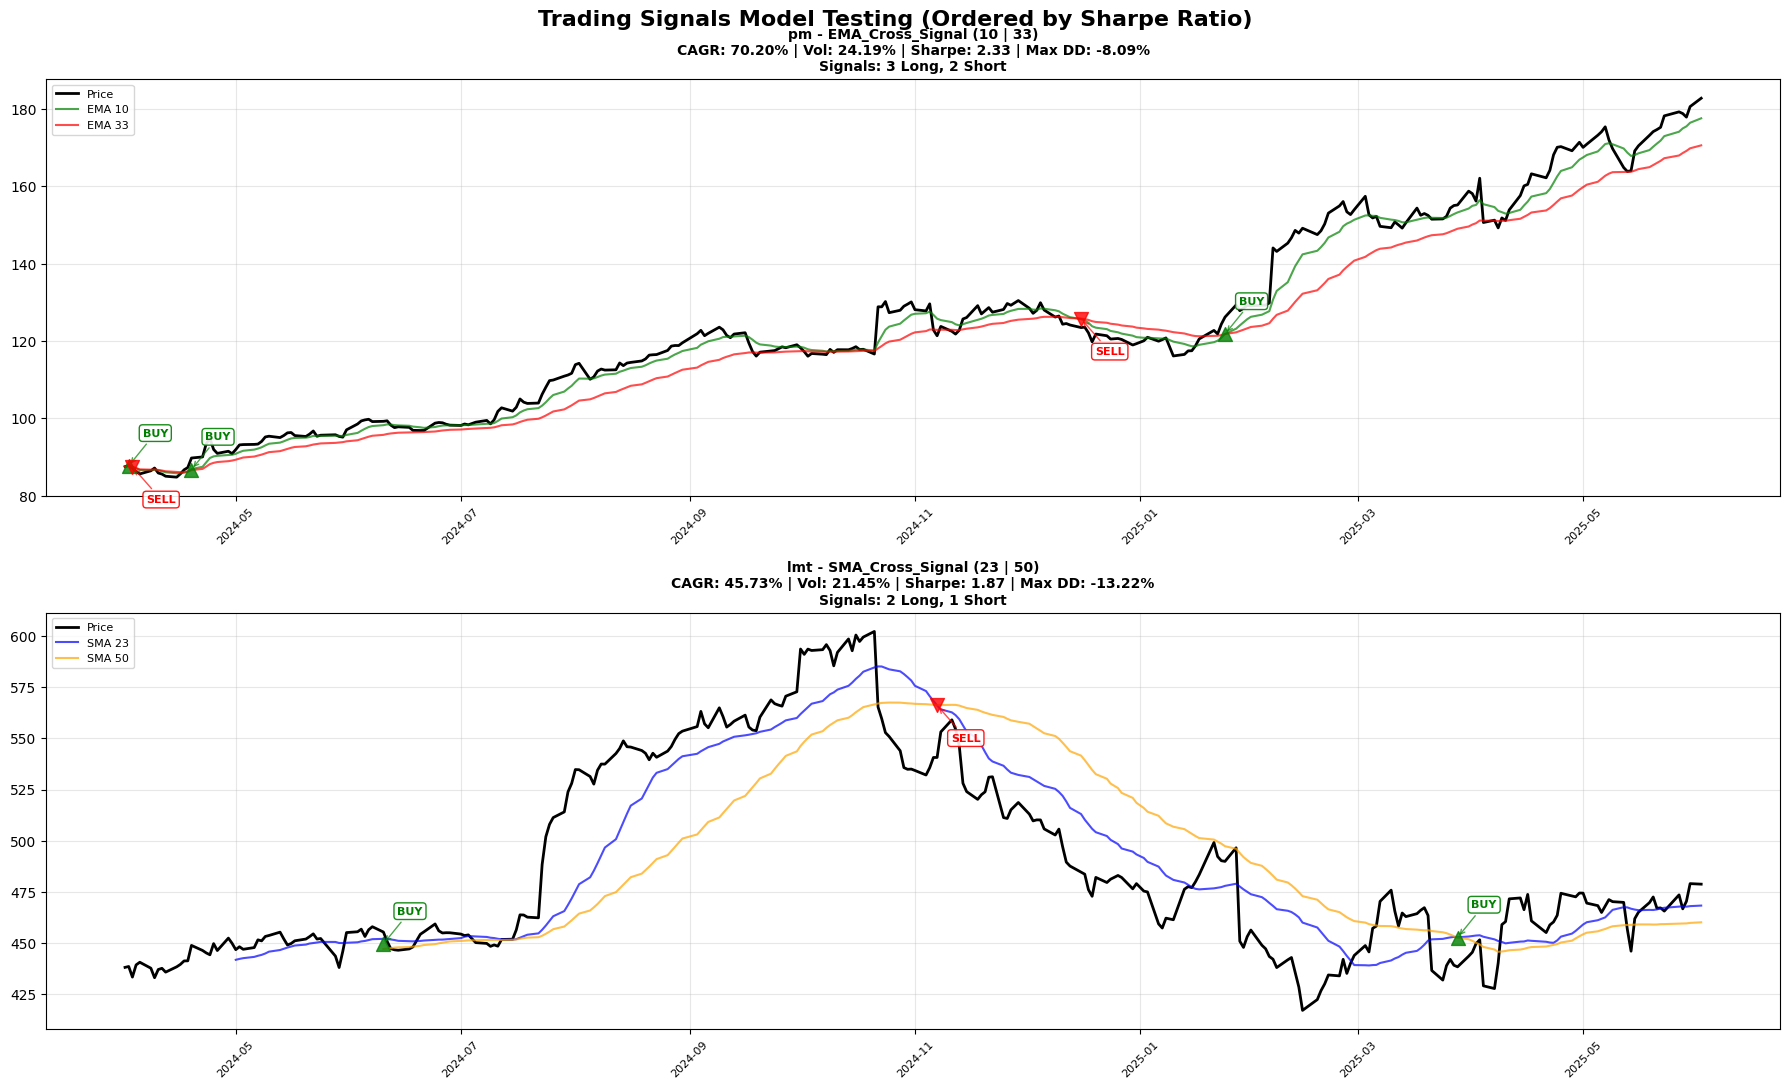


✅ Chart generation complete!


In [14]:
from py.technical_analysis import plot_parameter_comparison, plot_portfolio_performance, plot_optimization_metrics, plot_optimization_heatmaps, plot_ticker_signals_with_annotations

# Chart generation
print("📊 Generating Portfolio Charts...")

# Add parameter optimization plotting using optimization_summary DataFrame
if 'optimization_summary' in locals() and not optimization_summary.empty:
    print("\n📈 Parameter Optimization Visualization:")
    try:
        # Plot optimization heatmaps using optimization_results
        plot_optimization_heatmaps(optimization_results)
        
        # Create parameter comparison charts using optimization_summary
        plot_parameter_comparison(optimization_summary)
        
        # Plot performance metrics distribution using optimization_summary
        plot_optimization_metrics(optimization_summary)
        
    except Exception as e:
        print(f"Error plotting optimization results: {e}")

for chart_type, func in [("Portfolio Performance", lambda: plot_portfolio_performance(optimization_summary)), 
                         ("Strategy Signals by Ticker", lambda: plot_ticker_signals_with_annotations(
                             quotes, trading_signals, technical_indicators, 
                             optimization_summary)
                          if all([quotes is not None, trading_signals, technical_indicators,
                                 optimization_summary is not None and not optimization_summary.empty]) 
                          else print("⚠️ Missing required data or no optimization results"))]:
    try:
        print(f"\n📈 {chart_type}:")
        if chart_type == "Strategy Signals by Ticker" and not optimization_summary.empty:
            print(f"📋 Included tickers: {optimization_summary['Ticker'].tolist()}")
        func()
    except Exception as e:
        print(f"Error plotting {chart_type.lower()}: {e}")

print("\n✅ Chart generation complete!")

### Step 10: Merge Strategy with Fundamental + Sentiment Analysis Data

In [15]:
from py.utils import clean_column_names

print("Selected tickers from analysis_results:")
print(analysis_results['selected_tickers'])

# Create a DataFrame with tickers and merge with best_strategies_df
best_strategies_with_tickers = best_strategies_df.copy()
best_strategies_with_tickers['Ticker'] = [ticker.upper() for ticker in analysis_results['selected_tickers']] # Convert tickers to uppercase to match fundamentals_df format

# Convert to Polars for merging
best_strategies_pl = pl.DataFrame(best_strategies_with_tickers)

# Prepare comprehensive_screened for merging - select only needed columns
comprehensive_screened_for_merge = comprehensive_screened.select([
    'symbol',
    'articlesInLastWeek',
    'companyNewsScore', 
    'bearishPercent',
    'bullishPercent',
    'averageSentimentScore',
    'sectorAverageBullishPercent',
    'sectorAverageNewsScore'
    # Add other columns you want to keep, but exclude 'sector' to avoid duplication
]).with_columns(
    pl.col("symbol").str.to_uppercase().alias("Ticker")
).drop('symbol')  # Remove the original lowercase symbol column

# Chain all merges together
short_term_portfolio_pl = (fundamentals_df
    .join(best_strategies_pl, on='Ticker', how='inner')
    .join(comprehensive_screened_for_merge, on='Ticker', how='inner')
)

# Convert back to pandas if needed for further processing
short_term_portfolio_df = short_term_portfolio_pl.to_pandas()
short_term_portfolio_df = short_term_portfolio_df.set_index('Ticker').sort_index()
short_term_portfolio_df = clean_column_names(short_term_portfolio_df)
display(short_term_portfolio_df)

Selected tickers from analysis_results:
['lmt', 'pm']


,Date,Name,Sector,Industry,Country,Website,Market Cap,Enterprise Value,Float Shares,Shares Outstanding,...,Sharpe Ratio,Volatility,Strategy,Articles In Last Week,Company News Score,Bearish Percent,Bullish Percent,Average Sentiment Score,Sector Average Bullish Percent,Sector Average News Score
Ticker,,,,,,,,,,,,,,,,,,,,,
LMT,2025-06-02,Lockheed Martin Corporation,Industrials,Aerospace & Defense,United States,https://www.lockheedmartin.com,1.130197e+11,1.315207e+11,1.727323e+08,2.342960e+08,...,1.802865,0.214643,SMA_Cross_Signal,14,0.6124,0.0000,0.9286,0.2247,0.4822,0.5621
PM,2025-06-02,Philip Morris International Inc.,Consumer Defensive,Tobacco,United States,https://www.pmi.com,2.810919e+11,3.282564e+11,1.552579e+09,1.556520e+09,...,1.524161,0.234830,EMA_Cross_Signal,131,0.6205,0.0153,0.6870,0.2411,0.5040,0.5582


### Step 12: Export Potfolio to Excel

#### Prepare DataFrame for Export

In [16]:
# Merge Portfolio Daily Quotes with risk-free rate
daily_prices_df_merged = quotes[selected_tickers].join(daily_risk_free_df, how='inner')

# Convert all column names to uppercase
daily_prices_df_merged.columns = daily_prices_df_merged.columns.str.upper()

# Create a Monthly Price DataFrame
monthly_prices_df_merged = daily_prices_df_merged.copy()

# Make sure index is datetime (redundant if already datetime, but safe)
monthly_prices_df_merged.index = pd.to_datetime(monthly_prices_df_merged.index)

# Resample to monthly (start of month) and get the last value
monthly_prices_df_merged = (monthly_prices_df_merged
                           .resample('MS').last()
                           .reset_index()
                           .rename(columns={'index': 'Date'}))

# Set Index to Date
monthly_prices_df_merged.reset_index(drop=True, inplace=True)
monthly_prices_df_merged.set_index(['Date'], inplace=True)

# Display
display(monthly_prices_df_merged.sort_index(axis=0, ascending=False).sort_index(axis=1, ascending=True))

,LMT,PM,^IRX
Date,,,
2025-05-01,479.080017,180.589996,4.230
2025-04-01,474.481689,171.360001,4.190
2025-03-01,443.654022,158.729996,4.190
2025-02-01,444.011536,153.921326,4.193
2025-01-01,456.413940,129.060776,4.188
2024-12-01,479.079376,119.296959,4.208
2024-11-01,518.682251,130.447052,4.373
2024-10-01,534.985107,130.094116,4.432
2024-09-01,572.714722,119.016029,4.498


#### Export DataFrame to Excel

In [17]:
from py.utils import export_to_excel

export_to_excel(output_file, {
    'short_term': short_term_portfolio_df,
    'daily_quotes': daily_prices_df_merged,  
    'monthly_quotes': monthly_prices_df_merged   
})

Updated sheet 'short_term'
Successfully merged data into 'daily_quotes' sheet
Successfully merged data into 'monthly_quotes' sheet
Successfully exported all data to portfolios/portfolio-2025-06-02.xlsx
